# Bollinger Bands Indicator

**Formula:**
- **Middle Band** = SMA(close, window=20)
- **Upper Band** = Middle Band + (2 × Standard Deviation)
- **Lower Band** = Middle Band - (2 × Standard Deviation)
- **Bandwidth** = (Upper Band - Lower Band) / Middle Band
- **%B (Percent B)** = (Price - Lower Band) / (Upper Band - Lower Band)

**Interpretation:**
- **Squeeze**: When bands narrow (low bandwidth) → low volatility, potential breakout coming
- **Expansion**: When bands widen (high bandwidth) → high volatility, strong trend in motion
- **Price near Upper Band**: Overbought conditions (bullish but extended)
- **Price near Lower Band**: Oversold conditions (bearish but extended)
- **%B Indicator**:
  - %B > 1: Price above upper band (extremely overbought)
  - %B > 0.8: Approaching upper band
  - %B = 0.5: Price at middle band
  - %B < 0.2: Approaching lower band
  - %B < 0: Price below lower band (extremely oversold)

**Common Trading Strategies:**
1. **Mean Reversion**: Sell near upper band, buy near lower band
2. **Breakout**: Enter when price breaks bands + bands are expanding (volatility confirmation)
3. **Squeeze Trading**: Wait for bands to compress, enter when they expand
4. **Walking the Bands**: Strong trends "walk" along one band (follow trend, avoid counter-trend trades)

In [2]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from indikator.bollinger import bollinger_bands

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

2025-11-29 17:16:57.865 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'window' has constraints: {'ge': 2}
2025-11-29 17:16:57.866 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'epsilon' has constraints: {'gt': 0.0}
2025-11-29 17:16:57.868 | DEBUG    | hipr.config:configurable:705 - Creating Config for 'rvol' with 2 hyperparameter(s): ['window', 'epsilon']
2025-11-29 17:16:57.872 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'min_samples' has constraints: {'ge': 1}
2025-11-29 17:16:57.872 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'epsilon' has constraints: {'gt': 0.0}
2025-11-29 17:16:57.874 | DEBUG    | hipr.config:configurable:705 - Creating Config for 'rvol_intraday' with 2 hyperparameter(s): ['min_samples', 'epsilon']
2025-11-29 17:16:57.876 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'window' has constraints: {'ge': 1}
2025-11-29 17:16:57.878 | DEBUG    | hipr.config:confi

## Scenario 1: Bollinger Squeeze Followed by Volatility Breakout
Classic squeeze setup → expansion with strong directional move

/tmp/user/ipykernel_588679/3025217297.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


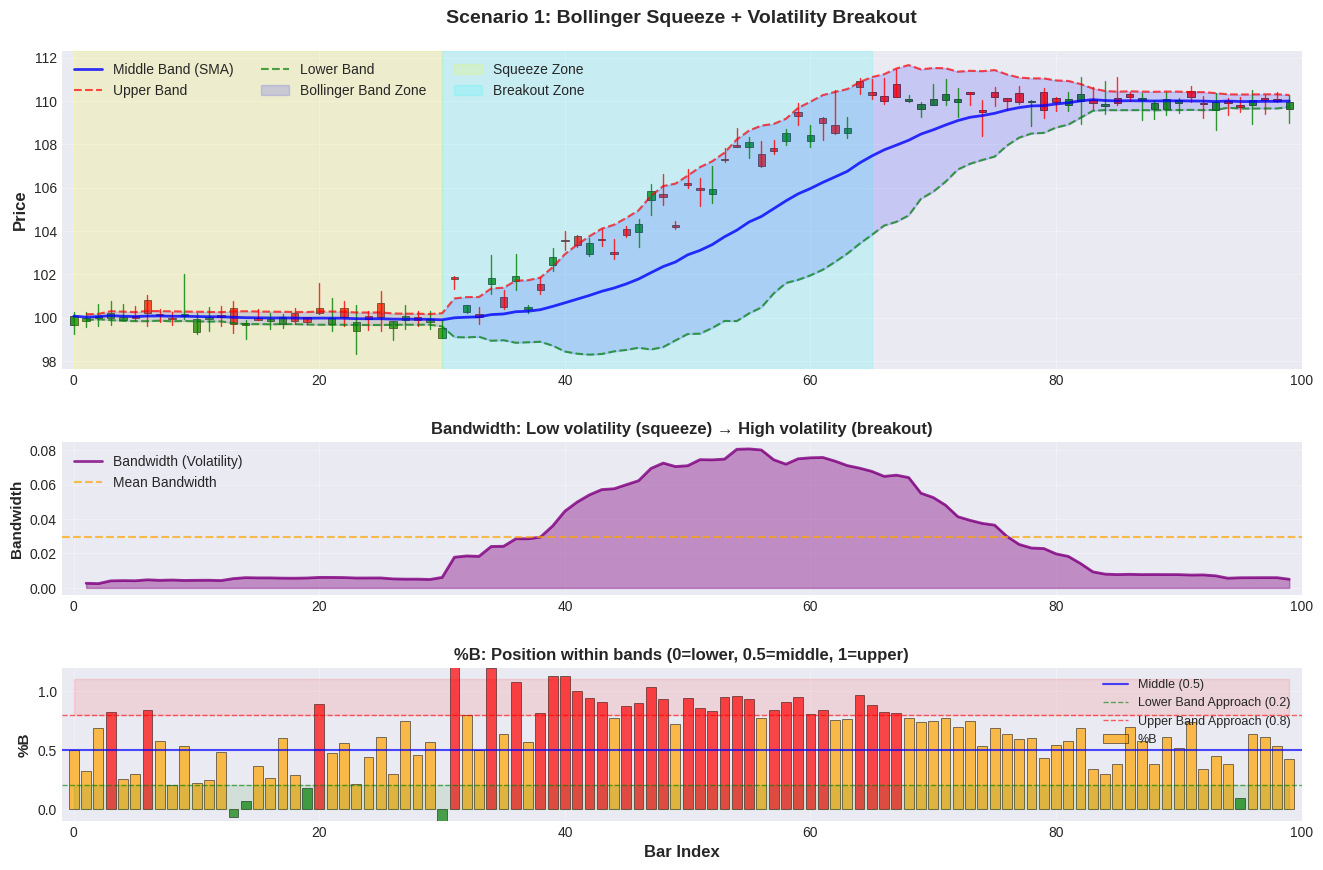


Squeeze Detection Analysis:
  Squeeze phase (0-30):
    Mean Bandwidth: 0.0055
    Band Width:     0.5459

  Breakout phase (30-65):
    Mean Bandwidth: 0.0558
    Band Width:     5.7696

  Bandwidth expanded by: 10.22x


In [3]:
# Create scenario: low volatility phase then breakout
n = 100
dates = pd.date_range('2024-01-01 09:30', periods=n, freq='5min')

# Phase 1: Squeeze (tight consolidation)
squeeze_phase = 100 + np.random.randn(30) * 0.15  # Very low noise

# Phase 2: Breakout up (strong expansion)
breakout_up = 100 + np.linspace(0, 10, 35) + np.random.randn(35) * 0.8

# Phase 3: Consolidation at higher level
higher_consolidation = 110 + np.random.randn(35) * 0.2

closes = np.concatenate([squeeze_phase, breakout_up, higher_consolidation])

# Create OHLC
opens = closes + np.random.randn(n) * 0.3
highs = np.maximum(opens, closes) + np.abs(np.random.randn(n)) * 0.5
lows = np.minimum(opens, closes) - np.abs(np.random.randn(n)) * 0.5
volumes = 1000 + np.random.randint(0, 500, n)

df = pd.DataFrame({
    'open': opens,
    'high': highs,
    'low': lows,
    'close': closes,
    'volume': volumes
}, index=dates)

# Calculate Bollinger Bands
bb = bollinger_bands(df['close'], window=20, num_std=2.0)

# Plot
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 1, height_ratios=[2.5, 1.2, 1.2], hspace=0.35)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Plot candlesticks
for i in range(len(df)):
    color = 'green' if df['close'].iloc[i] >= df['open'].iloc[i] else 'red'
    ax1.plot([i, i], [df['low'].iloc[i], df['high'].iloc[i]], color=color, linewidth=1, alpha=0.8)
    height = abs(df['close'].iloc[i] - df['open'].iloc[i])
    if height < 0.05:
        height = 0.1
    bottom = min(df['open'].iloc[i], df['close'].iloc[i])
    ax1.add_patch(plt.Rectangle(
        (i - 0.3, bottom), 0.6, height,
        facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8
    ))

# Bollinger Bands with shading
ax1.plot(range(len(df)), bb['bb_middle'], 'b-', linewidth=2, label='Middle Band (SMA)', alpha=0.8)
ax1.plot(range(len(df)), bb['bb_upper'], 'r--', linewidth=1.5, label='Upper Band', alpha=0.7)
ax1.plot(range(len(df)), bb['bb_lower'], 'g--', linewidth=1.5, label='Lower Band', alpha=0.7)
ax1.fill_between(range(len(df)), bb['bb_upper'], bb['bb_lower'], alpha=0.15, color='blue', label='Bollinger Band Zone')

# Highlight squeeze and breakout zones
ax1.axvspan(0, 30, alpha=0.15, color='yellow', label='Squeeze Zone')
ax1.axvspan(30, 65, alpha=0.15, color='cyan', label='Breakout Zone')

ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Scenario 1: Bollinger Squeeze + Volatility Breakout', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', ncol=3, fontsize=10)
ax1.set_xlim(-1, len(df))

# Bandwidth (volatility measure)
ax2.fill_between(range(len(df)), bb['bb_bandwidth'], alpha=0.4, color='purple')
ax2.plot(range(len(df)), bb['bb_bandwidth'], 'purple', linewidth=2, label='Bandwidth (Volatility)', alpha=0.8)
ax2.axhline(bb['bb_bandwidth'].mean(), color='orange', linestyle='--', linewidth=1.5, label='Mean Bandwidth', alpha=0.7)
ax2.set_ylabel('Bandwidth', fontsize=11, fontweight='bold')
ax2.set_title('Bandwidth: Low volatility (squeeze) → High volatility (breakout)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left', fontsize=10)
ax2.set_xlim(-1, len(df))

# %B Indicator
colors_b = np.where(bb['bb_percent'] > 0.8, 'red', np.where(bb['bb_percent'] < 0.2, 'green', 'orange'))
ax3.bar(range(len(df)), bb['bb_percent'], color=colors_b, alpha=0.7, edgecolor='black', linewidth=0.5, label='%B')
ax3.axhline(0.5, color='blue', linestyle='-', linewidth=1.5, label='Middle (0.5)', alpha=0.7)
ax3.axhline(0.2, color='green', linestyle='--', linewidth=1, label='Lower Band Approach (0.2)', alpha=0.6)
ax3.axhline(0.8, color='red', linestyle='--', linewidth=1, label='Upper Band Approach (0.8)', alpha=0.6)
ax3.fill_between(range(len(df)), 0.8, 1.1, alpha=0.1, color='red')
ax3.fill_between(range(len(df)), 0, 0.2, alpha=0.1, color='green')
ax3.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax3.set_ylabel('%B', fontsize=11, fontweight='bold')
ax3.set_title('%B: Position within bands (0=lower, 0.5=middle, 1=upper)', fontsize=12, fontweight='bold')
ax3.set_ylim(-0.1, 1.2)
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper right', fontsize=9)
ax3.set_xlim(-1, len(df))

plt.tight_layout()
plt.show()

print('\nSqueeze Detection Analysis:')
print(f'  Squeeze phase (0-30):')
print(f'    Mean Bandwidth: {bb["bb_bandwidth"].iloc[10:30].mean():.4f}')
print(f'    Band Width:     {(bb["bb_upper"].iloc[10:30] - bb["bb_lower"].iloc[10:30]).mean():.4f}')
print(f'\n  Breakout phase (30-65):')
print(f'    Mean Bandwidth: {bb["bb_bandwidth"].iloc[30:65].mean():.4f}')
print(f'    Band Width:     {(bb["bb_upper"].iloc[30:65] - bb["bb_lower"].iloc[30:65]).mean():.4f}')
print(f'\n  Bandwidth expanded by: {bb["bb_bandwidth"].iloc[30:65].mean() / bb["bb_bandwidth"].iloc[10:30].mean():.2f}x')

## Scenario 2: Walking the Bands (Strong Trending Market)
Strong uptrend that hugs the upper band (or downtrend along lower band)

/tmp/user/ipykernel_588679/2935240572.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


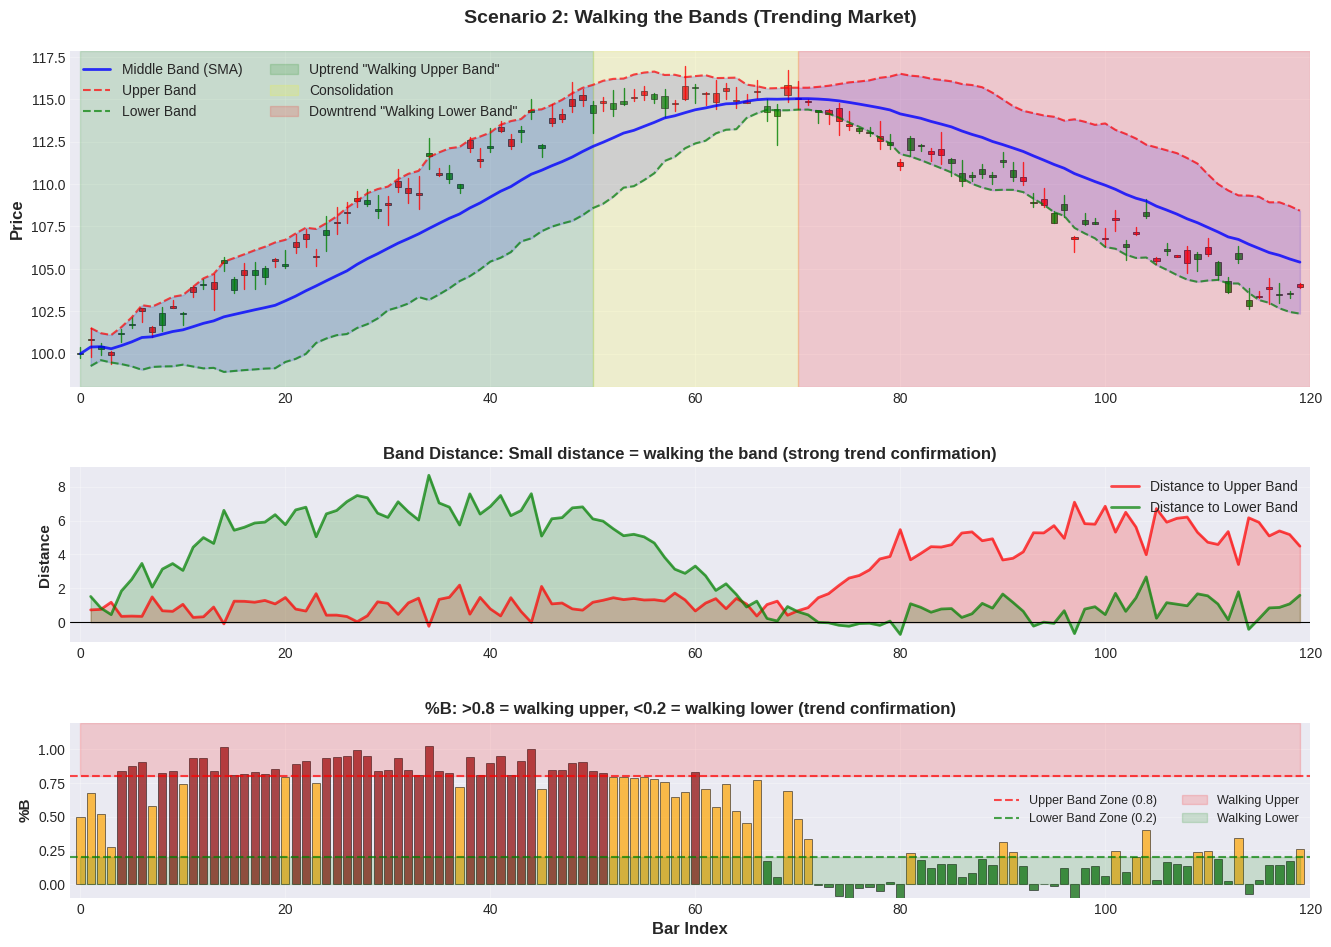


Walking the Bands Analysis:

  Uptrend phase (0-50):
    %B > 0.8 (walking upper): 40 bars (80.0%)
    Mean %B:                  0.837

  Consolidation phase (50-70):
    %B between 0.2-0.8:       15 bars (75.0%)
    Mean %B:                  0.662

  Downtrend phase (70-120):
    %B < 0.2 (walking lower): 38 bars (76.0%)
    Mean %B:                  0.115


In [4]:
# Create scenario: strong uptrend then downtrend
n2 = 120
dates2 = pd.date_range('2024-01-02 09:30', periods=n2, freq='5min')

# Phase 1: Strong uptrend
uptrend = 100 + np.linspace(0, 15, 50) + np.random.randn(50) * 0.6

# Phase 2: Peak and consolidation
peak_consolidation = 115 + np.random.randn(20) * 0.3

# Phase 3: Strong downtrend
downtrend = 115 - np.linspace(0, 12, 50) + np.random.randn(50) * 0.6

closes2 = np.concatenate([uptrend, peak_consolidation, downtrend])

# Create OHLC
opens2 = closes2 + np.random.randn(n2) * 0.3
highs2 = np.maximum(opens2, closes2) + np.abs(np.random.randn(n2)) * 0.5
lows2 = np.minimum(opens2, closes2) - np.abs(np.random.randn(n2)) * 0.5
volumes2 = 1200 + np.random.randint(0, 500, n2)

df2 = pd.DataFrame({
    'open': opens2,
    'high': highs2,
    'low': lows2,
    'close': closes2,
    'volume': volumes2
}, index=dates2)

# Calculate Bollinger Bands
bb2 = bollinger_bands(df2['close'], window=20, num_std=2.0)

# Calculate distance to bands
dist_to_upper = bb2['bb_upper'] - df2['close']
dist_to_lower = df2['close'] - bb2['bb_lower']

# Plot
fig = plt.figure(figsize=(16, 11))
gs = GridSpec(3, 1, height_ratios=[2.5, 1.3, 1.3], hspace=0.35)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Plot candlesticks
for i in range(len(df2)):
    color = 'green' if df2['close'].iloc[i] >= df2['open'].iloc[i] else 'red'
    ax1.plot([i, i], [df2['low'].iloc[i], df2['high'].iloc[i]], color=color, linewidth=1, alpha=0.8)
    height = abs(df2['close'].iloc[i] - df2['open'].iloc[i])
    if height < 0.05:
        height = 0.1
    bottom = min(df2['open'].iloc[i], df2['close'].iloc[i])
    ax1.add_patch(plt.Rectangle(
        (i - 0.3, bottom), 0.6, height,
        facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8
    ))

# Bollinger Bands
ax1.plot(range(len(df2)), bb2['bb_middle'], 'b-', linewidth=2, label='Middle Band (SMA)', alpha=0.8)
ax1.plot(range(len(df2)), bb2['bb_upper'], 'r--', linewidth=1.5, label='Upper Band', alpha=0.7)
ax1.plot(range(len(df2)), bb2['bb_lower'], 'g--', linewidth=1.5, label='Lower Band', alpha=0.7)
ax1.fill_between(range(len(df2)), bb2['bb_upper'], bb2['bb_lower'], alpha=0.15, color='blue')

# Highlight walking phases
ax1.axvspan(0, 50, alpha=0.15, color='green', label='Uptrend "Walking Upper Band"')
ax1.axvspan(50, 70, alpha=0.15, color='yellow', label='Consolidation')
ax1.axvspan(70, 120, alpha=0.15, color='red', label='Downtrend "Walking Lower Band"')

ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Scenario 2: Walking the Bands (Trending Market)', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', ncol=2, fontsize=10)
ax1.set_xlim(-1, len(df2))

# Distance to bands
ax2.plot(range(len(df2)), dist_to_upper, color='red', linewidth=2, label='Distance to Upper Band', alpha=0.7)
ax2.plot(range(len(df2)), dist_to_lower, color='green', linewidth=2, label='Distance to Lower Band', alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.fill_between(range(len(df2)), 0, dist_to_upper, alpha=0.2, color='red')
ax2.fill_between(range(len(df2)), 0, dist_to_lower, alpha=0.2, color='green')
ax2.set_ylabel('Distance', fontsize=11, fontweight='bold')
ax2.set_title('Band Distance: Small distance = walking the band (strong trend confirmation)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)
ax2.set_xlim(-1, len(df2))

# %B Indicator - shows if walking upper or lower band
colors_b2 = np.where(bb2['bb_percent'] > 0.8, 'darkred', np.where(bb2['bb_percent'] < 0.2, 'darkgreen', 'orange'))
ax3.bar(range(len(df2)), bb2['bb_percent'], color=colors_b2, alpha=0.7, edgecolor='black', linewidth=0.5)
ax3.axhline(0.8, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Upper Band Zone (0.8)')
ax3.axhline(0.2, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Lower Band Zone (0.2)')
ax3.fill_between(range(len(df2)), 0.8, 1.2, alpha=0.15, color='red', label='Walking Upper')
ax3.fill_between(range(len(df2)), 0, 0.2, alpha=0.15, color='green', label='Walking Lower')
ax3.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax3.set_ylabel('%B', fontsize=11, fontweight='bold')
ax3.set_title('%B: >0.8 = walking upper, <0.2 = walking lower (trend confirmation)', fontsize=12, fontweight='bold')
ax3.set_ylim(-0.1, 1.2)
ax3.grid(True, alpha=0.3)
ax3.legend(loc='center right', fontsize=9, ncol=2)
ax3.set_xlim(-1, len(df2))

plt.tight_layout()
plt.show()

print('\nWalking the Bands Analysis:')
print(f'\n  Uptrend phase (0-50):')
print(f'    %B > 0.8 (walking upper): {(bb2["bb_percent"].iloc[0:50] > 0.8).sum()} bars ({(bb2["bb_percent"].iloc[0:50] > 0.8).sum()/50*100:.1f}%)')
print(f'    Mean %B:                  {bb2["bb_percent"].iloc[0:50].mean():.3f}')
print(f'\n  Consolidation phase (50-70):')
print(f'    %B between 0.2-0.8:       {((bb2["bb_percent"].iloc[50:70] >= 0.2) & (bb2["bb_percent"].iloc[50:70] <= 0.8)).sum()} bars ({((bb2["bb_percent"].iloc[50:70] >= 0.2) & (bb2["bb_percent"].iloc[50:70] <= 0.8)).sum()/20*100:.1f}%)')
print(f'    Mean %B:                  {bb2["bb_percent"].iloc[50:70].mean():.3f}')
print(f'\n  Downtrend phase (70-120):')
print(f'    %B < 0.2 (walking lower): {(bb2["bb_percent"].iloc[70:120] < 0.2).sum()} bars ({(bb2["bb_percent"].iloc[70:120] < 0.2).sum()/50*100:.1f}%)')
print(f'    Mean %B:                  {bb2["bb_percent"].iloc[70:120].mean():.3f}')

## Key Takeaways

### Squeeze Trading Strategy
1. **Identify the Squeeze**: Look for low bandwidth values (bands compressed)
2. **Wait for Expansion**: Monitor for bandwidth increase
3. **Enter the Breakout**: 
   - Upbreak: Close above upper band + bandwidth expanding + volume increase
   - Downbreak: Close below lower band + bandwidth expanding + volume increase
4. **Set Stops**: Place stop-loss beyond the opposite band

### %B Indicator Usage
- **%B > 1.0**: Price above upper band → very overbought
- **%B > 0.8**: Approaching upper band → overbought
- **%B = 0.5**: At middle band → neutral
- **%B < 0.2**: Approaching lower band → oversold
- **%B < 0.0**: Price below lower band → very oversold

**%B Applications:**
- Mean reversion: Buy when %B < 0.2, sell when %B > 0.8
- Trend confirmation: %B > 0.8 in uptrend, %B < 0.2 in downtrend
- Divergence detection: Price makes new high but %B < 0.8

### Bandwidth Interpretation
- **Low Bandwidth** (< 0.05): Compression, low volatility
  - Price movement restricted
  - Traders consolidating
  - Breakout likely coming
  
- **High Bandwidth** (> 0.15): Expansion, high volatility
  - Price swings increasing
  - Strong trending conditions
  - Volatility breakout in progress

### Trading Rules

**For Squeeze Breakout:**
- Entry: Close outside band + bandwidth increasing
- Target: 2x the band width from breakout point
- Stop: Opposite band or midline

**For Walking the Bands:**
- Long: Price > middle band AND %B > 0.5 AND bandwidth expanding
- Short: Price < middle band AND %B < 0.5 AND bandwidth expanding
- Exit: Price touches opposite band or bandwidth contracts sharply

**Mean Reversion:**
- Sell Setup: %B > 0.8 + RSI > 70 + (optional: divergence)
- Buy Setup: %B < 0.2 + RSI < 30 + (optional: divergence)
- Target: Middle band (SMA)
- Stop: Outside the band

### Best Practices
1. **Combine with volume**: Breakouts should have volume confirmation
2. **Use multiple timeframes**: Confirm squeeze on higher timeframe
3. **Watch bandwidth changes**: Sharp increase = volatility event coming
4. **Don't trade the middle**: Avoid trading when %B ≈ 0.5 in sideways market
5. **Adjust parameters**: 
   - window=20, num_std=2 is standard (covers ~95% of price action)
   - window=10, num_std=2 for faster, more sensitive bands
   - window=50, num_std=2 for slower, trending markets
   - num_std=1 for tighter bands, num_std=3 for wider bands
6. **Filter by volatility**: Only trade breakouts when bandwidth was previously compressed

## Feature Showcase: Safety & Configuration

In [7]:
# Configuration & Validation Showcase
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from indikator.bollinger import bollinger_bands

# 1. Configuration with .Config()
print(f"--- Custom bollinger_bands Configuration ---")
# Create a fully configured version of the indicator
# This factory pattern validates parameters at creation time
custom_bollinger_bands = bollinger_bands.Config(window=30, num_std=2.5).make()
print(f"Created: {custom_bollinger_bands}")

# 2. Validation Safety
print(f"--- Input Validation Safety ---")
try:
    # Attempt to use invalid data (infinite values)
    invalid_data = pd.Series([100.0, float('inf'), 102.0]) # Infinite values
    print("Attempting calculation with invalid inputs...")
    bollinger_bands(invalid_data)
except Exception as e:
    # The @validated decorator automatically catches the issue
    print(f"✓ Validator caught error as expected:  {e}")


--- Custom bollinger_bands Configuration ---
Created: <function configurable.<locals>.make.<locals>.bound_fn at 0x76cc293739c0>
--- Input Validation Safety ---
Attempting calculation with invalid inputs...
✓ Validator caught error as expected:  Column 'close' not found in dataframe
